In [1]:
from datautils import get_dls
from src.models.resnet import ResNet
from src.models.patchTST import PatchTST
from src.learner import  transfer_weights
from torchinfo import summary
import torch.nn as nn
from src.basics import set_device
import torch

from src.callback.patch_mask import Patch
set_device()

class params:
    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [2]:
dls = get_dls(params(batch_size=1, dset='gunpoint', num_workers=1)) 

In [3]:
#model = ResNet(1, 'classification', 2, .2)
model = PatchTST(c_in=1,
                target_dim=2,
                patch_len=16,
                stride=8,
                num_patch=17,                
                n_layers=3,
                n_heads=16,
                d_model=128,
                shared_embedding=True,
                d_ff=256,                        
                dropout=.2,
                head_dropout=0,
                act='relu',
                head_type='classification',
                res_attention=False
                )    

In [4]:
#w_path = 'saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth'
w_path = 'saved_models/gunpoint/patchtst_supervised/based_model/patchtst_supervised_cw150_tw2_patch16_stride8_epochs30_model1.pth'
model = transfer_weights(weights_path=w_path, model=model, exclude_head=False, device='cuda')

weights from saved_models/gunpoint/patchtst_supervised/based_model/patchtst_supervised_cw150_tw2_patch16_stride8_epochs30_model1.pth successfully transferred!



In [5]:
model.eval()

PatchTST(
  (backbone): PatchTSTEncoder(
    (W_P): Linear(in_features=16, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (encoder): TSTEncoder(
      (layers): ModuleList(
        (0): TSTEncoderLayer(
          (self_attn): MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp_attn): ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.2, inplace=False)
            )
          )
          (dropout_attn): Dropout(p=0.2, inplace=False)
          (norm_attn): Sequential(
            (0): Transpose()
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [6]:
from scipy.spatial.distance import pdist, cdist, squareform

In [7]:
class GAP_Resnet(nn.Module):

    def __init__(self, model):
        super(GAP_Resnet, self).__init__()

        self.model = nn.Sequential(model.block1, model.block2, model.block3, model.gap)
        

    def forward(self, x):
        x = x.permute(0,2,1)
        out = self.model(x)
        return out

In [16]:
class GAP_PatchTST(nn.Module):

    def __init__(self, model):
        super(GAP_PatchTST, self).__init__()

        self.model = model.backbone
        self.patch = Patch(seq_len = 150, patch_len = 16, stride = 8)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.patch(x)
        out = self.model(x)
        out = out[:,:,:,-1]            
        out = self.flatten(out)  
        return out

In [9]:
gap_m = GAP_Resnet(model)

AttributeError: 'PatchTST' object has no attribute 'block1'

In [17]:
gap_p = GAP_PatchTST(model)

In [18]:
dl = iter(dls.train)


In [19]:
X, y = next(dl)

In [20]:
X = X.unsqueeze(-1)

In [21]:
X.shape

torch.Size([1, 150, 1])

In [22]:
gap_p(X.cuda()).shape

torch.Size([1, 128])

In [24]:
N = 50
X = []
X_GAP = []
Y = []
for _ in range(N):
    x, y = next(dl)
    x = x.unsqueeze(-1)
    X.append(x)
    Y.append(y)
    X_GAP.append(gap_p(x.cuda()))





In [25]:
def to_numpy(l):
    return [el.detach().cpu().numpy( ) for el in l ]

In [26]:
X_GAP = to_numpy(X_GAP)

In [27]:
Y = to_numpy(Y)
X = to_numpy(X)

In [28]:
import numpy as np

In [29]:
X = np.array(X)
X_GAP = np.array(X_GAP)

In [30]:
X = X.reshape(N,150)
X_GAP = X_GAP.reshape(N,128)

In [31]:
Xdist = squareform(pdist(X))

In [32]:
X_GAP_dist = squareform(pdist(X_GAP))

In [33]:
def stress(Xdist, X_GAP_dist):
    d_norm = np.sum(X_GAP_dist**2)
    up = np.sum((X_GAP_dist-Xdist)**2)
    return np.sqrt(up/d_norm)

In [34]:
stress(Xdist, X_GAP_dist)

0.6983227006703854

In [36]:
from sklearn.manifold import MDS

mds_gap = MDS(dissimilarity='precomputed', random_state=0)
X_transform = mds_gap.fit_transform(X_GAP_dist)

In [37]:
import matplotlib.pyplot as plt

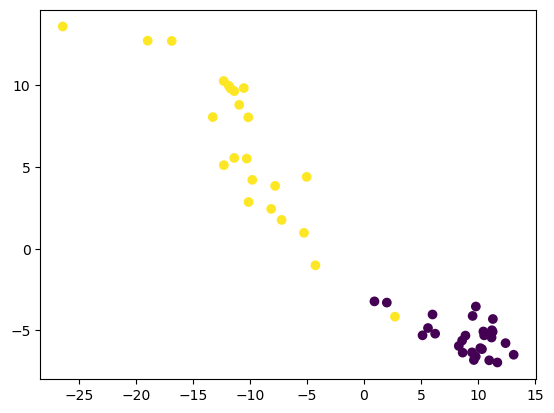

In [38]:
plt.scatter(X_transform[:,0], X_transform[:,1], c=np.ravel(Y))
plt.show()

In [39]:
mds_raw = MDS(random_state=0)
X_transform = mds_raw.fit_transform(X)

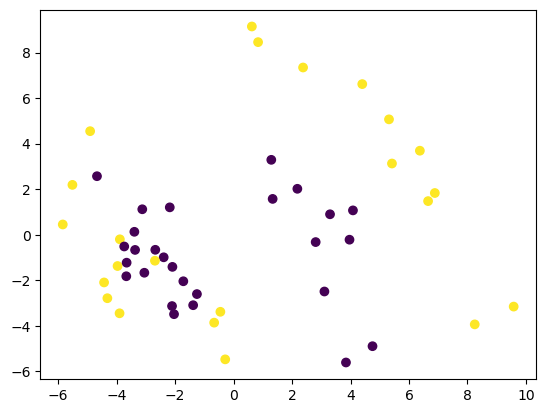

In [40]:
plt.scatter(X_transform[:,0], X_transform[:,1], c=np.ravel(Y))
plt.show()